In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_default_device", jax.devices()[2])
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from importlib import reload
# import KernelTools
# reload(KernelTools)
from KernelTools import *
# from EquationModel import InducedRKHS,OperatorModel,CholOperatorModel
from EquationModel import CholInducedRKHS, OperatorPDEModel, OperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from Kernels import log1pexp,inv_log1pexp, get_gaussianRBF
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from Optimizers import (CholeskyLM, 
                        SVD_LM,
                        LMParams,
                        plot_optimization_results)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results, get_nrmse    
from matplotlib import ticker
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

/home/juanfelipe/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# coeffs of Burgers eqn
kappa = 0.001
alpha = 5.
# IC
def func_u0(x):
    u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    return u0
# solve Burgers eqn                            
u_true_function,ut_true_function,interp,t_vals,sols = (
    build_burgers_data(func_u0=func_u0,
                        kappa = kappa,
                        alpha = alpha,
                        k_timestep=0.0001,
                        n_finite_diff=1999)
)

100%|██████████| 10099/10099 [00:04<00:00, 2503.54it/s]


In [3]:
# size of coll grid
num_grid_x, num_grid_t = 31, 26

# get interior and bdry pts of coll grid
tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],
                                        num_grid_t,
                                        num_grid_x,
                                        alpha = 0.5
)

# coll grid and obs grid
seed = 55
n_obs = 60
tx_all, tx_obs = setup_problem_data(tx_int,
                                    tx_bdy,
                                    n_obs,
                                    jax.random.PRNGKey(seed),
                                    times_to_observe = (0,)
)

# u vals at coll grid
u_all = u_true_function(tx_all)

# u vals at obs grid
u_obs = u_true_function(tx_obs)

In [4]:
# fine grid
num_fine_grid = 300
t_fine, x_fine = jnp.meshgrid(jnp.linspace(0,1,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
# u vals at fine grid
u_true = u_true_function(tx_fine)

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

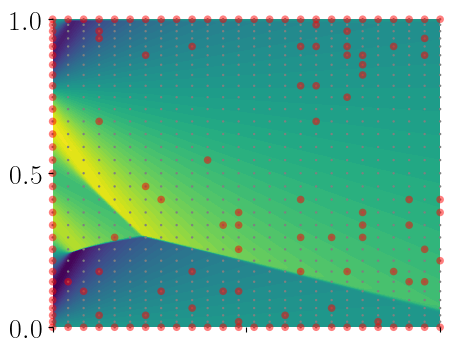

In [5]:
# u_true plot
plt.figure(figsize=(5,4))
plt.tricontourf(*tx_fine.T, u_true,
                levels= 70, 
                vmin=-0.453787655164269,
                vmax=0.3887784971499098)
# coll grid
plt.scatter(*tx_all.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs.T,
            c='red', 
            s = 30, 
            alpha = 0.5,
            clip_on =False,
            edgecolors = 'none')

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([])
plt.gca().set_xticklabels([]) 

In [6]:
# x fine grid
xfine = jnp.linspace(0,1,num_fine_grid)
# u vals at fine grid at IC
u_true_IC = u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid), xfine]).T)
# u vals at fine grid at FC
u_true_FC = u_true_function(jnp.vstack([1.0*jnp.ones(num_fine_grid), xfine]).T)

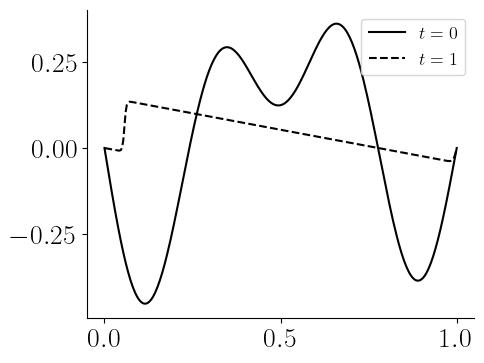

In [7]:
# u_true IC and FC plot
plt.figure(figsize=(5,4))
# Plot IC
plt.plot(xfine, u_true_IC,
         color = 'black',
         label = r'$t=0$')
# Plot FC
plt.plot(xfine,u_true_FC,
         linestyle = '--',
         color = 'black',
         label = r'$t=1$')

# fig settings
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc="upper right",fontsize = 13)

### PINNSR

In [9]:
# get formatted data to input into PINNSR
def get_data_for_pinns(n_obs, num_grid_t, num_grid_x,run):
    
    # coeffs of Burgers eqn
    kappa = 0.001
    alpha = 5.
    # IC
    def func_u0(x):
        u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
        return u0
    # solve Burgers eqn                            
    u_true_function,ut_true_function,interp,t_vals,sols = (
        build_burgers_data(func_u0=func_u0,
                            kappa = kappa,
                            alpha = alpha,
                            k_timestep=0.0001,
                            n_finite_diff=1999)
    )
    

    # get interior and bdry pts of coll grid
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],
                                            num_grid_t,
                                            num_grid_x,
                                            alpha = 0.5
    )

    # coll grid and obs grid
    tx_all, tx_obs = setup_problem_data(tx_int,
                                        tx_bdy,
                                        n_obs,
                                        jax.random.PRNGKey(run),
                                        times_to_observe = (0,)
    )

    # u vals at coll grid
    u_all = u_true_function(tx_all)

    # u vals at obs grid
    u_obs = u_true_function(tx_obs)

    # fine grid
    num_fine_grid = 300
    t_fine, x_fine = jnp.meshgrid(jnp.linspace(0,1,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    # u vals at fine grid
    u_true = u_true_function(tx_fine)

    ### u true plot
    plt.figure(figsize=(5,4))
    plt.tricontourf(*tx_fine.T, u_true,
                    levels= 70, 
                    vmin=-0.453787655164269,
                    vmax=0.3887784971499098)
    # coll grid
    plt.scatter(*tx_all.T,
                c='gray',
                s = 3,
                clip_on =False, 
                edgecolors = 'none')
    # obs grid
    plt.scatter(*tx_obs.T,
                c='red', 
                s = 30, 
                alpha = 0.5,
                clip_on =False,
                edgecolors = 'none')

    # fig settings
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=3)
    plt.gca().set_xticklabels([])
    plt.gca().set_xticklabels([]) 
    ###
    
    # Invert them to be ready for PINNSR 
    tx_train = tx_obs
    u_train = u_true_function(tx_train)
    
    tx_val = jax.random.choice(key = jax.random.PRNGKey(0), a = tx_fine, shape = (int(jnp.ceil(tx_train.shape[0]*(1-0.8)/0.8)),), replace=False)
    u_val = u_true_function(tx_val)
    
    #limits
    lb = tx_fine.min(0)
    ub = tx_fine.max(0)
    

    tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

    tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

    tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

    tx_all = jnp.vstack([tx_all,tx_train])

    

    return [u_true, tx_train, u_train, tx_all, tx_val, u_val, lb, ub]

  0%|          | 0/10099 [00:00<?, ?it/s]

100%|██████████| 10099/10099 [00:03<00:00, 2595.22it/s]


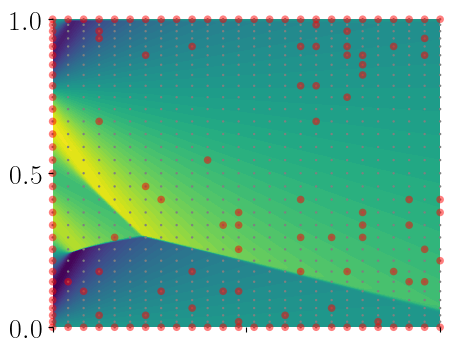

In [10]:
# get data
data_in_PINNSR_test = get_data_for_pinns(n_obs=60,num_grid_t=26, num_grid_x=31, run=55)
# convert to numpy
data_in_PINNSR_test = list(map(np.array,data_in_PINNSR_test))

In [11]:
# save data to be used in PINNSR env
np.save('data_in_PINNSR_test.npy', np.array(data_in_PINNSR_test, dtype=object), allow_pickle=True)

In [12]:
# read output data from PINNSR
data_out_PINNSR_test = jnp.load('data_out_PINNSR_test.npy',allow_pickle = True)

In [13]:
# u_pred vals at fine grid
u_pred = data_out_PINNSR_test[1].flatten()

[Text(0, 0.0, ''), Text(0, 0.5, ''), Text(0, 1.0, '')]

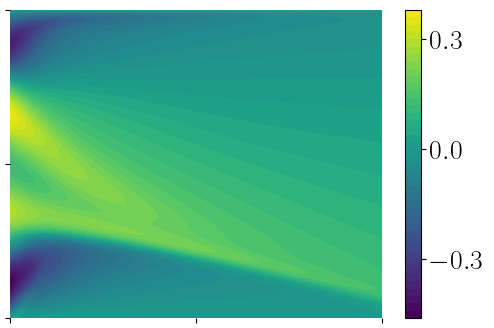

In [14]:
# u_pred plot
plt.figure(figsize=(6,4))
cp = plt.tricontourf(*tx_fine.T,
                     u_pred,
                     levels = 70,
                     vmin= -0.453787655164269, 
                     vmax= 0.3887784971499098)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([]) 
# plt.savefig('shock_u_pred_PINNSR.pdf',
#             dpi=300,
#             bbox_inches='tight',
#             format ="pdf"
#             )

[Text(0.0, 0, ''), Text(0.5, 0, ''), Text(1.0, 0, '')]

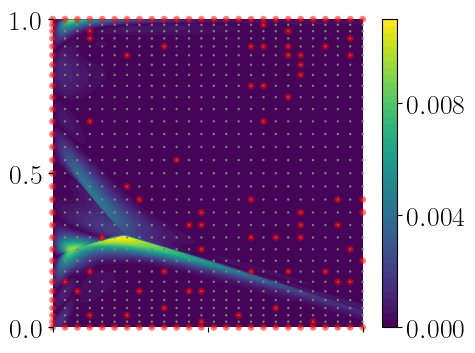

In [15]:
# u errors plot
plt.figure(figsize=(5,4))
cp = plt.tricontourf(*tx_fine.T, jnp.abs(u_true - u_pred)/jnp.linalg.norm(u_true),
                levels= 50)
# coll grid
plt.scatter(*tx_all.T,
            c='gray',
            s = 3,
            clip_on =False, 
            edgecolors = 'none')
# obs grid
plt.scatter(*tx_obs.T,
            c='red', 
            s = 25, 
            alpha = 0.5,
            clip_on =False,
            edgecolors = 'none')

# colorbar
cb = plt.colorbar(cp)

# fig settings
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=3)
tick_locator = ticker.MaxNLocator(nbins=3)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_xticklabels([]) 

In [16]:
# store data
data = {'tx_obs': tx_obs,
        'tx_all': tx_all,
        'tx_int': tx_int,
        'tx_bdy': tx_bdy,
        'tx_fine': tx_fine,
        'xfine': xfine,
        'u_true': u_true,
        'u_pred': u_pred,
        'u_true_IC': u_true_IC,
        'u_true_FC': u_true_FC
}

In [17]:
# save data
np.save('data.npy', np.array(data, dtype=object), allow_pickle=True)